# Session 1
## Implementing a 2D simulation of Active Brownian Particles (ABP) in Python.

### Overview of the problem

#### Description of the model

Let us consider a two-dimensional system consisting of $N$ identical disks of radius $a$. The instantaneous position of disk $i$ is given by the radius vector $\mathbf{r}_i = x_i\mathbf{e}_x+y_i\mathbf{e}_y$. In addition, each disk is polar and its polarity is described by a vector $\mathbf{n}_i = \cos(\vartheta_i)\mathbf{e}_x + \sin(\vartheta_i)\mathbf{e}_y$, where $\vartheta_i$ is angle between $\mathbf{n}_i$ and the $x-$axis of the laboratory reference frame. It is immediately clear that $\left|\mathbf{n}_i\right| = 1$.

Disks are assumed to be soft, i.e., they repel each other if they overlap. The interaction force is therefore short-range and, for simplicity, we assume it to be harmonic, i.e., the force between disks $i$ and $j$ is
\begin{equation}
\mathbf{F}_{ij} = 
\begin{cases} 
    k\left(2a - r_{ij}\right)\hat{\mathbf{r}}_{ij} & \text{if } r_{ij} \le 2a \\ 
    0 & \text{otherwise}
\end{cases},\label{eq:force}
\end{equation}
where $k$ is the spring stiffness constant, $\mathbf{r}_{ij} = \mathbf{r}_i - \mathbf{r}_j$, $r_{ij} = \left|\mathbf{r}_{ij}\right|$ is the distance between particles $i$ and $j$ and $\hat{\mathbf{r}}_{ij} = \frac{\mathbf{r}_{ij}}{r_{ij}}$. 

Furthermore, overlapping disk are assumed to experience torque that acts to align their polarities. Torque on disk $i$ due to disk $j$ is 
\begin{equation}
\boldsymbol{\tau}_{ij} = 
\begin{cases} 
    J\mathbf{n}_i\times\mathbf{n}_j & \text{if } r_{ij} \le 2a \\ 
    0 & \text{otherwise}
\end{cases}\label{eq:torque},
\end{equation}
where $J$ is the alignment strength. Note that since we are working in two dimensions, $\boldsymbol{\tau}_{ij} = \tau_{ij}\mathbf{e}_z$. It is easy to show that $\tau_{ij} = -J\sin\left(\vartheta_i-\vartheta_j\right)$. 

Finally, each disk is self-propelled along the direction of its vector with a force 
\begin{equation}
\mathbf{F}_i = \alpha \mathbf{n}_i,\label{eq:spforce}
\end{equation}
where $\alpha$ is the magnitude of the self-propulsion force.

Key ingredients of the model are show in the figure below:

<div align="center">
<img src="./system.png" style="width: 800px;"/>
</div>

#### Equations of motion
    
In the overdamped limit, all inertial effects are neglected and the equations of motion become simply force (and torque) balance equations. For the model defined above we have,
\begin{eqnarray}
    \dot{\mathbf{r}}_i & = & v_0 \mathbf{n}_i + \frac{1}{\gamma_t}\sum_j \mathbf{F}_{ij} + \boldsymbol{\xi}^{t}_{i}\\
    \dot{\vartheta}_i & = & -\frac{1}{\tau_r}\sin\left(\vartheta_i-\vartheta_j\right) + \xi_i^r.\label{eq:motion_theta}
\end{eqnarray}
In previous equations we introduced the translational and rotational friction coefficients, $\gamma_t$ and $\gamma_r$, respectively and defined $v_0 = \frac{\alpha}{\gamma_t}$ and $\tau_r = \frac{\gamma_r}{J}$. Note that $v_0$ has units of velocity (hence we interpret it as the self-propulsion speed) while $\tau_r$ has units of time (hence we interpret it as the polarity alignment time scale). $\boldsymbol{\xi}_i^t$ is the white noise, which we here assume to be thermal noise (in general, this assumption is not required for a system out of equilibrium), i.e., $\langle\xi_{i,\alpha}\rangle=0$ and $\langle \xi_{i,\alpha}^t(t)\xi_{j,\beta}^t(t^\prime)\rangle = 2\frac{k_BT}{\gamma_t}\delta_{ij}\delta_{\alpha\beta}\delta(t-t^\prime)$, with $\alpha, \beta \in \{x, y\}$ and $T$ being temperature. Similarly, $\xi_i^r$ is the rotational noise, with $\langle\xi_i^r\rangle = 0$ and $\langle \xi_i^r(t)\xi_j^r(t^\prime)\rangle = 2D_r\delta_{ij}\delta(t-t^\prime)$, where we have introduced the rotational diffusion coefficient $D_r$.

<div align="center">
<font size="5" color="#990000"><b>The purpose of this tutorial is to develop a computer code that solves these equations of motion.</b></font>
</div>

<div class="alert alert-block alert-warning">
    <b>Note:</b> In this session we will sacrifice performance for clarity. Codes presented here are not optimized and quite often the implementation is very inefficient. This has been done deliberately in order not to obfuscate the key concepts. 

Our design philosophy, however, is to split the problem into a set of loosely coupled modules. This makes testing and maintenance simple.
</div>

### Overview of a particle-based simulation

A typical particle-based simulation workflow consists of three steps:

1. Creating the initial configuration; 
2. Executing the simulation; 
3. Analyzing the results.

The standard workflow is: step 1 feeds into step 2, which, in turn feeds into step 3. 

<div class="alert alert-block alert-info">
Depending on the approach and the problem at hand, sometimes these three steps are done by the same code. In line with our key design philosophy of keeping things as detached from each other as possible, in this tutorial we treat these three steps as independent. The communication between different steps will be based on a shared file format, i.e., a code written to perform step 1 will produce output files in a format that the code in step 2 can directly read, etc.
</div>

#### Creating the initial configuration

In the first step, we need to generate the system we would like to study, i.e. we need to create the initial configuration for our simulation. Sometimes, as it is the case here, this is a fairly simple task. However, creating a proper initial configuration can also be a challenging task in its own right that requires a set of sophisticated tools to do. A good example would be setting up a simulation of several complex biomolecules.

Regardless of the complexity, typically the result of this step is one (or several) text (sometimes binary) files that contain information such as the size of the simulation box, initial positions and velocities of all particles, particle connectivities, etc.

In this tutorial, we will use a set of simple Python scripts (located in *Python/pymd/builder* directory) to create the initial configuration that will be saved as a single JSON file.

For example, let us build the initial configuration with a square simulation box of size $L=50$ with the particle number density $\phi=\frac{N}{L^2}=0.4$. We also make sure that centers of no two particles less than $a=1$ apart. 
<div class="alert alert-block alert-warning">
Neither $L$ not $a$ have units here. We'll get back to the issue of simulation units below.
</div>

In [1]:
from pymd.builder import *
phi = 0.4
L = 50
a = 1.0
random_init(phi, L, rcut=a, outfile='init.json')  

A simple inspection of the file *init.json* confirms that $N=1000$ particles have been created in the simulation box of size $50\times50$.

<div class="alert alert-block alert-info">
    <b>Note:</b> In this tutorial we will aways assume the simulation box is orthogonal and centered at $(0,0)$. In other words, for simulation box of size $L_x=50$, $L_y=40$, all particles are located in the rectangle with corners at $(-25,-20)$, $(25,-20)$, $(25,20)$, $(-25,20)$.
</div>

#### Executing the simulation 

This step (i.e., step 2) is the focus of this tutorial. Conceptually, this step is straightforward - we need to write a program that solves the set equations for motion for a collection of $N$ particles placed in the simulation box. In practice, this is technically the most challenging step and some of the most advanced particle based codes can contain hundreds of thousands of lines of code. 

The problem is that equations of motions are coupled, i.e., we are tasked with solving the N-body problem. Therefore, any naive implementation would be so slow that it would not be possible to simulate even the simplest systems within any reasonable time. For this reason, even the most basic particle based codes have to implement several algorithms that make the problem tractable. Furthermore, any slightly more complex problem would require parallelization, which is the topic of the last session in this tutorial. 

#### Analyzing the results

Once the simulation in the step 2 has been completed, we need to perform a series of measurements to extract as much physical information about our system as possible. Although sometimes some basic analysis can be done by the main simulation code (i.e., in step 2), this is typically done a posteriori with a separate set of tools. Technically speaking, the main simulation code produces a file (or a set of files), often referred to as *trajectories*, that are loaded into the analysis code for post-processing. 

One of the key steps in the post-processing stage is visualization, e.g. making a movie of the time evolution of the system. Therefore, most simulation codes are able to output the data in multiple file formats for various types of post-processing analysis.

In this tutorial we will output the data in JSON and VTP formats. VTP files can be directly visualized with the powerful [Paraview](https://www.paraview.org/) software package. 

<div class="alert alert-block alert-info">
    <b>Note:</b> There are many excellent codes that perform step 2. For example, these are: GROMACS, LAMMPS, HOOMD Blue, ESPResSo, AMBER, DLPOLY, to name a few. Our aim is not to replace any of those codes but to showcase in a simple example the core of what these codes do.
</div>


### Writing a particle based simulation in Python

Here we outline the key parts of a modern implementation of a particle-based simulation. We use Python for its simple syntax and powerful data structures.

#### Periodic boundary conditions

Before we dive deep into the inner workings of a particle-based code, let us quickly discuss the use of the periodic boundary conditions (PBC). 

Even the most advanced particle-based simulations can simulate no more than several million particles. Most simulations are far more modest in size. A typical experimental system usually contains far more particles than it would be possible to simulate. Therefore, most simulations study a small section of an actual system and extrapolate the results onto the experimentally relevant scales. It is, therefore, important to minimize the finite size effects. One such approach is to use the  periodic boundary conditions.

The idea behind PBC is that the simulation box is assumed to have the topology of a torus. That is, a particle that leaves the simulation box through the left boundary would instantaneously reappear on the right side of the simulation box. This implies that when computing the distance between two particles one has to consider all of their periodic images and pick the shortest distance. This is called the *minimum image convention*.

The idea behind the minimum image convention is shown in the image below.

<div align="center">
    
<img src="./pbc.png" style="width: 600px;"/>
</div>
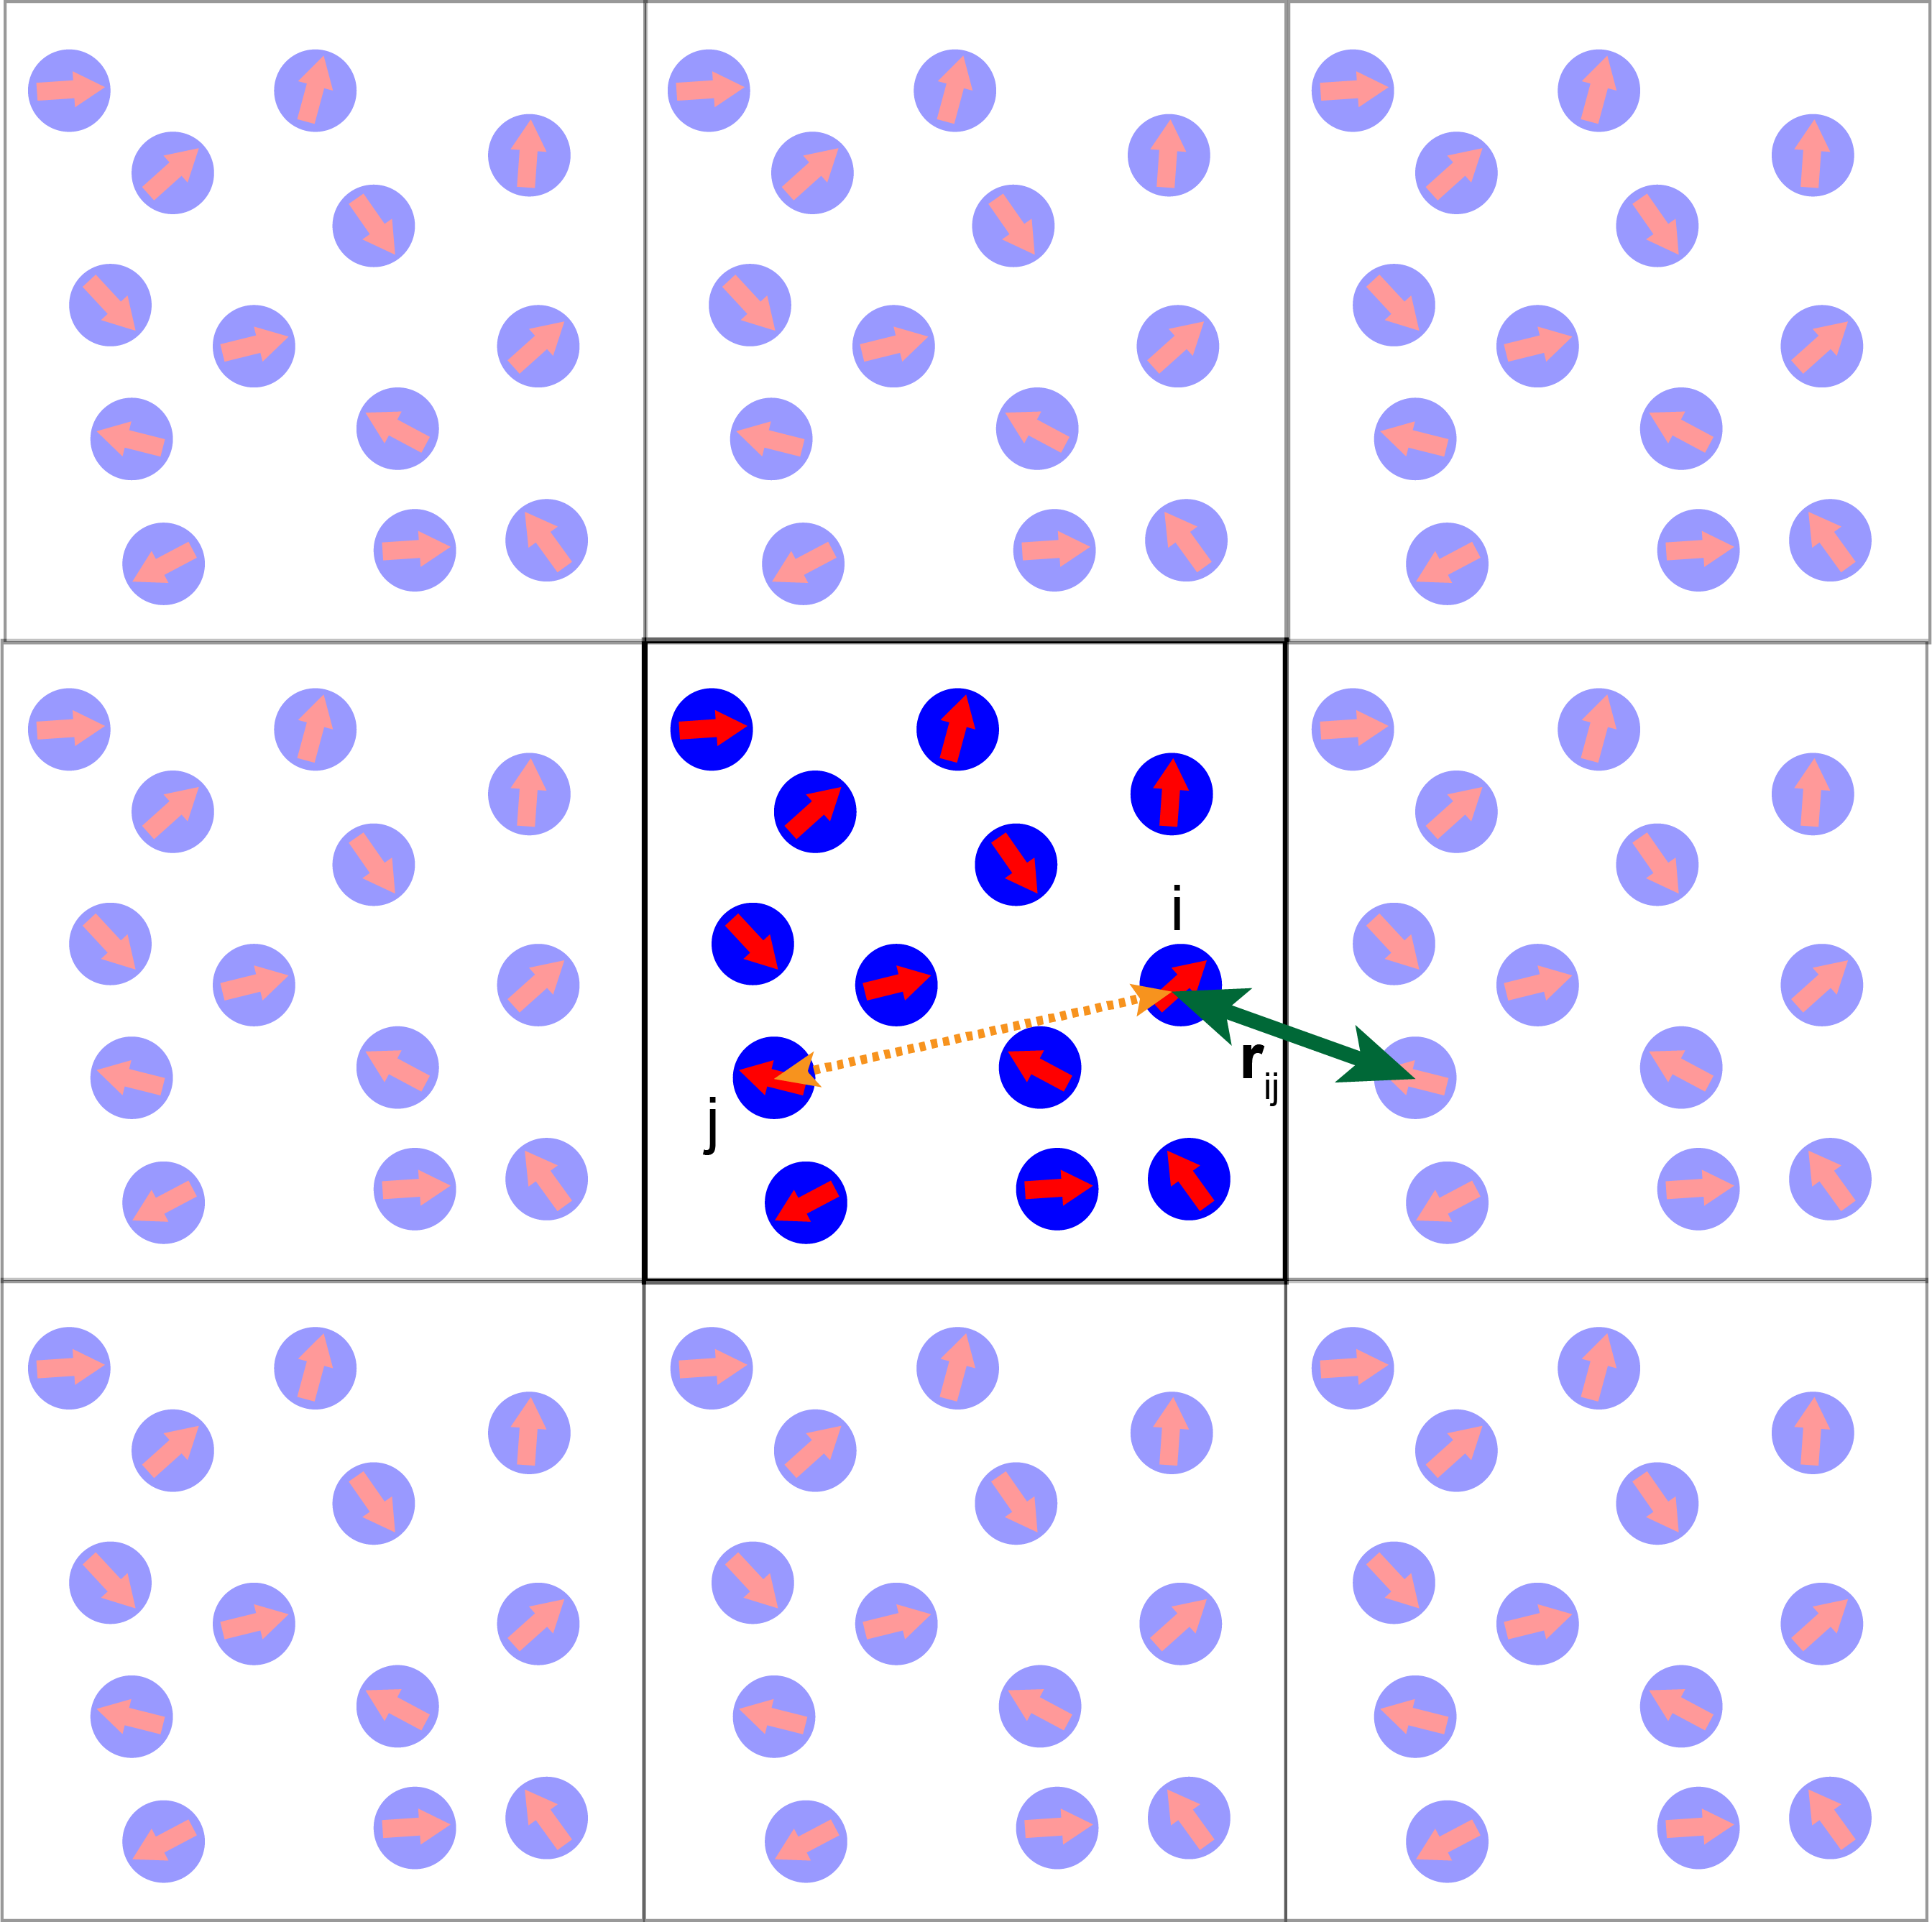

#### Key components of a particle-based simulation code

The image below shows the key components of a particle-based code and a possible design layout of how to organize them.

<div align="center">
    
<img src="./layout.png" style="width: 800px;"/>
</div>
<div class="alert alert-block alert-warning">
    <b>Note:</b> This is one of many design layouts that can be used. The one chosen here reflects our design philosophy of minimizing the interdependence of different components of the code. In addition, it naturally fits with the aim to use Python as the scripting language for controlling the simulation.</div>
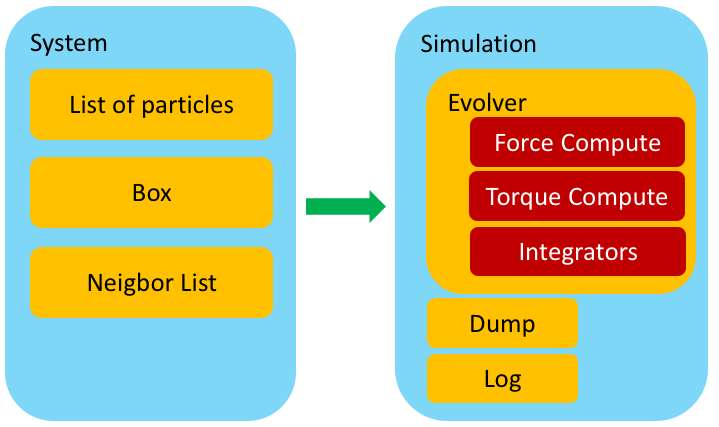

#### A working example

Let us start with a working example of a full simulation. 

We read the initial configuration stored in the file *init.json* with $N=1,000$ randomly placed particles in a square box of size $L=50$. We assume that all particles have the same radius $a=1$. Further, each particle is self-propelled with the active force of magnitude $\alpha=1$ and experiences translational friction with friction coefficient $\gamma_t = 1$. Rotational friction is set to $\gamma_r = 1$ and the rotational diffusion constant to $D_r = 0.1$. Particles within the distance $d=2$ of each other experience the polar alignment torque of magnitude $J=1$.

We use the time step $\delta t = 0.01$ and run the simulation for $1,000$ time steps. We record a snapshot of the simulation once every 10 time steps.

In [2]:
from pymd.md import *               # Import the md module from the pymd package

s = System(rcut = 3.0, pad = 0.5)   # Create a system object with neighbour list cutoff rcut = 3.0 and padding distance 0.5
s.read_init('init.json')            # Read in the initial configuration

e = Evolver(s)                      # Create a system evolver object
d = Dump(s)                         # Create a dump object

hf = HarmonicForce(s, 10.0, 2.0)    # Create pairwise repulsive interactions with the spring contant k = 10 and range a = 2.0
sp = SelfPropulsion(s, 1.0)         # Create self-propulsion, self-propulsion strength alpha = 1.0
pa = PolarAlign(s, 1.0, 2.0)        # Create pairwise polar alignment with alignment strength J = 1.0 and range a = 2.0

pos_integ = BrownianIntegrator(s, T = 0.0, gamma = 1.0)       # Integrator for updating particle position, friction gamma = 1.0 and no thermal noise
rot_integ = BrownianRotIntegrator(s, T = 0.1, gamma = 1.0)    # Integrator for updating particle oriantation, friction gamma = 1.0, "rotation" T = 0.1, D_r = 0.0 

# Register all forces, torques and integrators with the evolver object
e.add_force(hf)                    
e.add_force(sp)
e.add_torque(pa)
e.add_integrator(pos_integ)
e.add_integrator(rot_integ)

In [3]:
dt = 0.01    # Simulation time step
# Run simulation for 1,000 time steps (total simulation time is 10 time units)
for t in range(1000):
  print("Time step : ", t)
  e.evolve(dt)       # Evolve the system by one time step of length dt
  if t % 10 == 0:    # Produce snapshot of the simulation once every 10 time steps
    d.dump_vtp('test_{:05d}.vtp'.format(t))

Time step :  0
Time step :  1
Time step :  2
Time step :  3
Time step :  4
Time step :  5
Time step :  6
Time step :  7
Time step :  8
Time step :  9
Time step :  10
Time step :  11
Time step :  12
Time step :  13
Time step :  14
Time step :  15
Time step :  16
Time step :  17
Time step :  18
Time step :  19
Time step :  20
Time step :  21
Time step :  22
Time step :  23
Time step :  24
Time step :  25
Time step :  26
Time step :  27
Time step :  28
Time step :  29
Time step :  30
Time step :  31
Time step :  32
Time step :  33
Time step :  34
Time step :  35
Time step :  36
Time step :  37
Time step :  38
Time step :  39
Time step :  40
Time step :  41
Time step :  42
Time step :  43
Time step :  44
Time step :  45
Time step :  46
Time step :  47
Time step :  48
Time step :  49
Time step :  50
Time step :  51
Time step :  52
Time step :  53
Time step :  54
Time step :  55
Time step :  56
Time step :  57
Time step :  58
Time step :  59
Time step :  60
Time step :  61
Time step :  62
Ti

##### A note on units
<div class="alert alert-block alert-warning">
So far we have been rather loose with the units. For example, we set $L=50$ without specifying what "50" means in terms of real physical units. 

We actually work in the "simulation units", i.e., all numbers as quoted appear in the implementation of the force and torque laws as well as in the equations of motion, i.e. no parameters are rescaled. In other words, from the implementation point of view, all equations given above have been non-dimensionalized. It is up the the user to give the physical interpretation to the values of parameter used.

For example, we can work in the system of units where radius of a particle sets the unit of length. In this case, we would have $L=50a$. Similarly, we could have set the unit of time $t^*=\frac{\gamma_t}{k}$, in which case the time step $\delta t = 0.01t^*$ and the $\frac{\gamma_r}{J}$ would have to be expressed in terms of $t^*$, etc.

To put it rather mundanely, the computer does not care if the units are correct and what they mean. It is up to the simulator to assign physical meaning to what these parameters.
</div>

### Step by step guide through the working example

Let us now dissect the example above line by line and look into what is going on under the hood.  

In order to use the pymd package we need to load it. In particular, we import the md module.


In [31]:
from pymd.md import *

The source code on the entire module can be found in the *ABPtutotial/Python* directory. 

#### Creating the System object

In the following line, we crate an instance of the *System* class. The *System* class stores the system we are simulating and the information about the simulation box. It is also in charge of reading the initial configuration from a JSON file and it also builds and updates the neighbor list. 

In [32]:
s = System(rcut = 3.0, pad = 0.5)   # Create a system object with neighbour list cutoff rcut = 3.0 and padding distance 0.5
s.read_init('init.json')            # Read in the initial configuration

In our example, the instance of the *System* class is created with the neighbor list cutoff set to $r_{cut}=3.0$ and padding distance $d_{pad}=0.5$. For the system parameters used below, this corresponds approximately to 10 steps between neighbor list rebuilds.

After the *System* object has been created, we call the *read_init* member function to read in the size of the simulation box and the initial location and direction of the polarity vector for each particle.

*System* class is a part of the pymd.md core.

##### A note on neighbor lists
<div class="alert alert-block alert-info">
Neighbor list is one of the central parts of almost every particle-based code and yet is has almost nothing to do with physics. It is, however, a very handy tool to speed up calculations of forces and torques. Namely, with the exception of dealing with charged systems, most particle-particle interactions as pairwise and short-range. In other words, each particle interacts only with a handful of its immediate neighbors. In the example we study here, each particle interacts only with particles it overlaps with. 
    
The most time consuming part of the simulation is the computation of forces acting on each particle. This computation has to be performed at each time step. At the face value, it is an $O(N^2)$ problem as for every particle one has to loop over the entire system. One can half the time by using the third Newton's law. However, in practice, this is usually not enough. For example, for a modest system with $10^3$ particles, the "force loop" would have to iterate $\sim10^6$ times. 
    
For a system with short range interactions it is immediately clear that the vast majority of terms in this double loop will be equal to zero. Therefore, it is highly beneficial to keep track of who the neighbors of each particle are and only include them in the calculation. The performance gain of this approach is hard to exaggerate, however, it comes at the cost of significant increase in code complexity, i.e., neighbor lists are not easy to implement.
</div>

<div class="alert alert-block alert-info">
The idea is, however, simple. We keep a list of neighbors for each particle. All neighbors are within some cutoff distance (typically comparable to the interaction range). This cutoff is extended by a padding distance. If any of the particles moves more than half of the padding distance there is no longer guarantee that the current neighbor list represents the true state of the system and it has to be rebuild. Typically, one chooses the padding such that the neighbor list is rebuilt once every 10-20 time steps. This often requires some experimenting with parameters.
    
In this tutorial, we use so-called cell lists to improve the speed of neighbor list rebuilds. This approach is efficient for dense systems. For systems with low density, it is more optimal to use octtrees (or quadtrees in 2d). However, this is beyond the scope of this tutorial.
</div>

Below is a visual representation of a neighbor list:
<div align="center">
    
<img src="./nlist.png" style="width: 600px;"/>
</div>

#### The Evolver class

Now that we have created the *System* object and populated it with the initial configuration, we proceed to create the *Evolver* object:

In [33]:
e = Evolver(s)                      # Creates an evolver object

The *Evolver* class is the workhorse of our toy simulation. It's central member function is *evolve* which performs the one step of the simulation. It's task is to:

1. Ensure that the neighbor list is up to date;
2. Perform the integration pre-step;
3. Compute all forces and torques on each particle;
4. Perform the integration post-step;
5. Apply periodic boundary conditions.

In our design, one can have multiple force and torque laws apply in the system. In addition, multiple integrators can act in the same system. More about what this means below.

*Evolver* class is a part of the pymd.md core.

#### The Dump class

The *Dump* class handles output of the simulation run. This is the most important part of the code for interacting with the postprocessing analysis tools. It takes snapshots of the state of the system at a given instance in time and saves it to a file of a certain type. Here, we support outputs in JSON and VTP formats.

*Dump* class is a part of the pymd.md core.

In [34]:
d = Dump(s)                         # Create a dump object

#### Forces and torques

In our implementation, each non-stochastic term in equations of motion is implemented as a separate class. Terms in the equation of motion for particle's position are all given a generic name *force* while terms that contribute to the orientation of particle's polarity are called *torque*. Note particles in our model are disks and that rotating a disk will not stir the system, so the term *torque* is a bit loose. 

All *forces* and *torques* are stored in two lists in the *Evolver* class. The *evolve* member function of the *Evolver* class ensured that in each time step forces and torques on every particle are set to zero, before they are recomputed term by term.

While this design introduces some performance overhead (e.g., distances between particles have to be compute multiple times in the same time step), it provides great level flexibility since adding an additional term to the equations of motion requires just implementing a new *Force* class and adding it to the *Evolver*'s list of forces.

These classes are defined in the *forces* and *torques* directories. 

In [35]:
hf = HarmonicForce(s, 10.0, 2.0)    # Create pairwise repulsive interactions with spring contant k = 10 and range 2.0
sp = SelfPropulsion(s, 1.0)         # Create self-propulsion, self-propulsion strength alpha = 1.0
pa = PolarAlign(s, 1.0, 2.0)        # Create pairwise polar alignment with alignment strength J = 1.0 and range 2.0

# Register all forces, torques and integrators with the evolver object
e.add_force(hf)                    
e.add_force(sp)
e.add_torque(pa)

#### Integrators

Finally, the equations of motion are solved numerically using a discretization scheme. This is done by a set of classes that we call *Integrator* classes. Each of these classes implement one of the standard discretization schemed for solving a set of coupled ODEs. In the spirit of our modular design, solver of each equation of motion is implemented as a separate *Integrator* class allowing the code to be modular and simple to maintain.

In our example, both equations of motion are overdamped and not stiff. However, both equations of motion contain stochastic terms. Therefore, in both cases we implement the simple first-order Euler-Maruyama scheme.

For the equation of motion for particle's position with time step $\delta t$, the discretization scheme (e.g., for the $x-$component of the position of particle $i$) is:

$x_i(t+\delta t) = x_i(t) + \delta t\left(v_0 n_{i,x} - \frac{1}{\gamma_t}\sum_j k\left(2a - r_{ij}\right)\frac{x_i}{r_{ij}} \right) + \sqrt{2\frac{T}{\gamma_r}\delta t}\mathcal{N}(0,1)$, 

where $\mathcal{N}(0,1)$ is a random number drawn from a Gaussian distribution with the zero mean and unit variance. This integrator is implemented in the *BrownianIntegrator* class. 

The implementation for the direction of the particle's orientation is similar and is implemented in the *BrownianRotIntegrator* class. Note that, for convenience, in this class we also introduced a parameter $T$, such that the rotation diffusion coefficient is defined as $D_r = \frac{T}{\gamma_r}$. 

##### A note on numerical integration of equation of motion
<div class="alert alert-block alert-info">

Discretization of a set of ordinary equations of motion has be a field of active research in applied mathematics. Choosing the right method depends on the properties of the system of equations of interest and can often be very involved, especially if one requires a very accurate method (e.g., in studies of planetary dynamics). In the soft and active matter simulations, in most cases, using simple first- and second-order discretization schemes is usually sufficient. Since we are interested in collective behavior of a large number of particles and those particles scatter off of each other frequently, the precise knowledge of the trajectory of each particle is not essential.
    
In the case where inertial terms are not neglected, equations of motion are of the second order and a solving them with a simple first-order Euler method is usually not sufficient. However, the standard second order integrator, such as the half-step velocity-Verlet method is typically sufficient. The key difference between first-order integrators used in this example and a velocity-Verlet scheme is that the later involves a "pre-step" (i.e., a half-step of length $\frac{\delta t}{2}$) before forces and torques are computed. In order to make implementing such integrators in our code, each integrator class defines *prestep* and *poststep* member function. *prestep* (*poststep*) is invoked before (after) forces and and torques are computed.
</div>

<div class="alert alert-block alert-info">
Two particularly pedagogical texts on the theory behind numerical integration of equations of motion are:

1. Benedict Leimkuhler and Sebastian Reich, Simulating Hamiltonian Dynamics, Cambridge University Press, 2005. 
2. Ben Leimkuhler and Charles Matthews, Molecular Dynamics: With Deterministic and Stochastic Numerical Methods, Springer; 2015 edition.
</div>

In [36]:
pos_integ = BrownianIntegrator(s, T = 0.0, gamma = 1.0)       # Integrator for updating particle position, friction gamma = 1.0 and no thermal noise
rot_integ = BrownianRotIntegrator(s, T = 0.1, gamma = 1.0)    # Integrator for updating particle oriantation, friction gamma = 1.0, "rotation" T = 0.1, D_r = 0.0 

# add the two integrtors to the Evolver's list of integrtors
e.add_integrator(pos_integ)
e.add_integrator(rot_integ)

#### Iterating over time

Now that we have all ingredients in place, we can run a simulation. In our implementation, this is just a simple "for" loop over the predefined set of time steps. Inside this loop we perform the basic data collection, e.g., saving snapshots of the state of the system.

In [9]:
dt = 0.01    # Simulation time step
# Run simulation for 1,000 time steps (total simulation time is 10 time units)
for t in range(1000):
  print("Time step : ", t)
  e.evolve(dt)       # Evolve the system by one time step of length dt
  if t % 10 == 0:    # Produce snapshot of the simulation once every 10 time steps
    d.dump_vtp('test_{:05d}.vtp'.format(t))

Time step :  0
Time step :  1
Time step :  2
Time step :  3
Time step :  4
Time step :  5
Time step :  6
Time step :  7
Time step :  8
Time step :  9
Time step :  10
Time step :  11
Time step :  12
Time step :  13
Time step :  14
Time step :  15
Time step :  16
Time step :  17
Time step :  18
Time step :  19
Time step :  20
Time step :  21
Time step :  22
Time step :  23
Time step :  24
Time step :  25
Time step :  26
Time step :  27
Time step :  28
Time step :  29
Time step :  30
Time step :  31
Time step :  32
Time step :  33
Time step :  34
Time step :  35
Time step :  36
Time step :  37
Time step :  38
Time step :  39
Time step :  40
Time step :  41
Time step :  42
Time step :  43
Time step :  44
Time step :  45
Time step :  46
Time step :  47
Time step :  48
Time step :  49
Time step :  50
Time step :  51
Time step :  52
Time step :  53
Time step :  54
Time step :  55
Time step :  56
Time step :  57
Time step :  58
Time step :  59
Time step :  60
Time step :  61
Time step :  62
Ti

#### Final remarks on implementation 

In the case of a full production-grade code, it would be convenient to add several more components. For example:

*Logger* classes would be in charge of handling logging of various observables that can be compute on "fly", such as the total energy of the system (arguably, of not much use in an active, self-propelled system), pressure, stress, etc. 

*Event* classes would be reporting key events, such as reporting if the new *force* term was added, what is the frequency of saving the data, etc.

It would also be useful to save the entire state of the simulation (i.e., all parameters for each particle and all forces, torques and integrators) for future restarts.

One of the key parts of any good code, which is, unfortunately, often overlooked is having a set of **automatic tests**. As the code grows in complexity, making sure that adding new features does not break the expected behavior of the existing components becomes a challenging task. A modular design that decouples different parts of the code from each other as much as possible, together with a powerful set of automatic tests is essential to make this task tractable. 

### Visualizing results

There are many excellent tools for visualizing the results of a particle-based simulation. Commonly used are VMD, PyMol and Chimera, to name a few. In this tutorial we use Paraview.

### Analyzing results of a simulation

This is the third step in the simulation workflow. Once we have collected particle trajectories it is time to extract relevant information about the system. In this step we learn something new about the system we study and, in many ways, this the key and most creative step in doing simulation-based research. Addressing the the analysis of simulation results could be a subject of a long series of tutorials.